## 時系列データ分析の実習

### ライブラリをインストールする

In [ ]:
# sktimeとpmdarimaをpipでインストール
!pip install sktime==0.24.1 pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 7.9 MB/s eta 0:00:00


### データを読み込む

In [ ]:
# CSVファイルをダウンロード
!wget https://techacademy.s3.amazonaws.com/bootcamp/python/machine-learning/bitcoin_close_data_2017-01-01_2022-12-31.csv

--2024-09-01 21:25:28--  https://techacademy.s3.amazonaws.com/bootcamp/python/machine-learning/bitcoin_close_data_2017-01-01_2022-12-31.csv
Resolving techacademy.s3.amazonaws.com (techacademy.s3.amazonaws.com)... 52.219.199.93, 52.219.152.57, 52.219.152.53, ...
Connecting to techacademy.s3.amazonaws.com (techacademy.s3.amazonaws.com)|52.219.199.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42654 (42K) [text/csv]
Saving to: ‘bitcoin_close_data_2017-01-01_2022-12-31.csv’

bitcoin_close_data_ 100%[===================>]  41.65K  --.-KB/s    in 0.1s    

2024-09-01 21:25:29 (284 KB/s) - ‘bitcoin_close_data_2017-01-01_2022-12-31.csv’ saved [42654/42654]



In [ ]:
# PandasでCSVファイルを読み込む
import pandas as pd
btc_csv = pd.read_csv('bitcoin_close_data_2017-01-01_2022-12-31.csv')

In [ ]:
# btc_csvの先頭5行を表示
btc_csv.head()

,date,price
0,2017-01-01,995.4
1,2017-01-02,1017.0
2,2017-01-03,1033.3
3,2017-01-04,1135.4
4,2017-01-05,989.3


In [ ]:
# btc_csvの末尾5行を表示
btc_csv.tail()

,date,price
2186,2022-12-27,16706.1
2187,2022-12-28,16546.2
2188,2022-12-29,16636.4
2189,2022-12-30,16607.2
2190,2022-12-31,16537.4


In [ ]:
# price列のみでSeries型のデータを作る
btc_price = btc_csv["price"]

# date列の内容をPeriodIndex型に変換してbtc_priceのインデックスに設定する
btc_price.index = pd.PeriodIndex(btc_csv["date"], freq="D")

# btc_priceの先頭5行を表示
btc_price.head()

,price
date,
2017-01-01,995.4
2017-01-02,1017.0
2017-01-03,1033.3
2017-01-04,1135.4
2017-01-05,989.3


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='price'>)

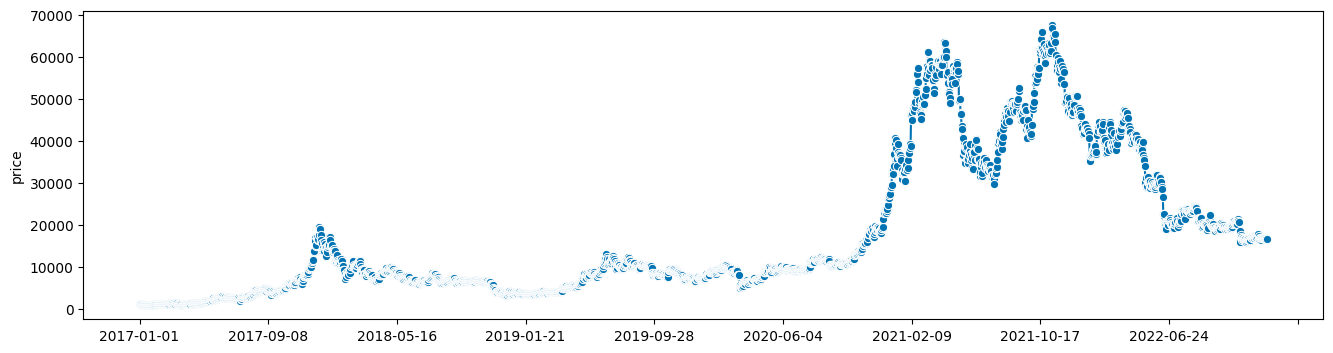

In [ ]:
# btc_priceの散布図を描く
from sktime.utils.plotting import plot_series

plot_series(btc_price)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='price'>)

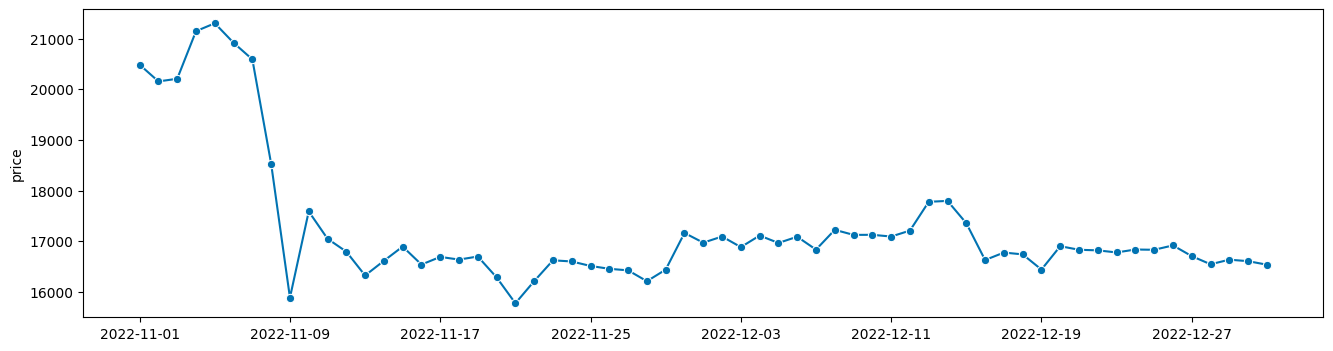

In [ ]:
# 2022年11月から2022年12月末までに絞って散布図を描く
plot_series(btc_price.tail(61))

### データを訓練データとテストデータに分ける

In [ ]:
# 訓練データとテストデータを分ける（テストデータは2022年12月のみ）
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(btc_price, test_size = 31)

In [ ]:
# y_trainの先頭5行を表示
y_train.head()

,price
2017-01-01,995.4
2017-01-02,1017.0
2017-01-03,1033.3
2017-01-04,1135.4
2017-01-05,989.3


In [ ]:
# y_trainの末尾5行を表示
y_train.tail()

,price
2022-11-26,16456.5
2022-11-27,16425.6
2022-11-28,16211.7
2022-11-29,16440.4
2022-11-30,17163.9


In [ ]:
# y_testの先頭5行を表示
y_test.head()

,price
2022-12-01,16972.0
2022-12-02,17093.6
2022-12-03,16884.5
2022-12-04,17112.6
2022-12-05,16966.5


In [ ]:
# y_testの末尾5行を表示
y_test.tail()

,price
2022-12-27,16706.1
2022-12-28,16546.2
2022-12-29,16636.4
2022-12-30,16607.2
2022-12-31,16537.4


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='price'>)

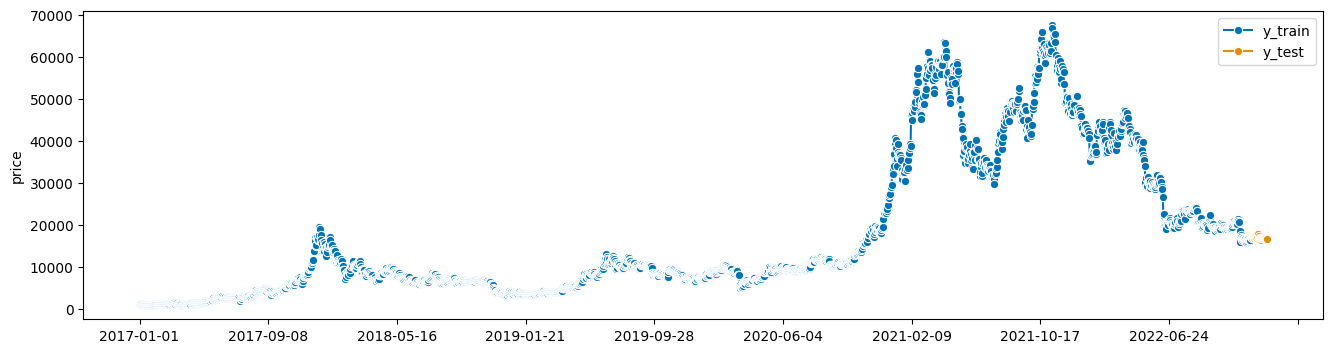

In [ ]:
# y_train と y_test で散布図を描く
plot_series(y_train, y_test, labels=["y_train", "y_test"])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='price'>)

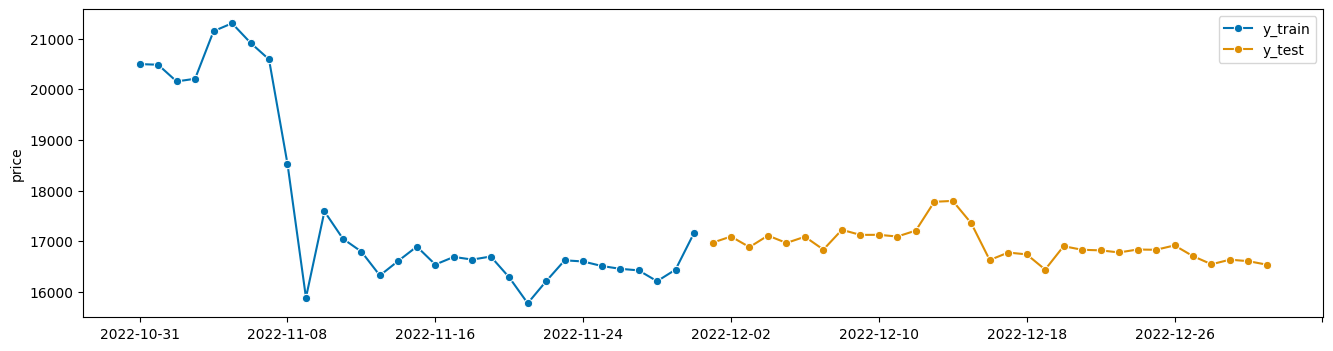

In [ ]:
# 2022年11月から2022年12月末までに絞って散布図を描く
plot_series(y_train.tail(31), y_test, labels=["y_train", "y_test"])

### モデルを作成して訓練する

In [ ]:
# ARIMAモデルを自動作成する
from sktime.forecasting.arima import AutoARIMA

model = AutoARIMA(suppress_warnings=True)

In [ ]:
# モデルを学習させる
model.fit(y_train)

AutoARIMA(suppress_warnings=True)

### 期待する性能が出たかを評価する

In [ ]:
# y_test のインデックスを取得する
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2022-12-01', '2022-12-02', '2022-12-03', '2022-12-04',
             '2022-12-05', '2022-12-06', '2022-12-07', '2022-12-08',
             '2022-12-09', '2022-12-10', '2022-12-11', '2022-12-12',
             '2022-12-13', '2022-12-14', '2022-12-15', '2022-12-16',
             '2022-12-17', '2022-12-18', '2022-12-19', '2022-12-20',
             '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
             '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
             '2022-12-29', '2022-12-30', '2022-12-31'],
            dtype='period[D]', is_relative=False)

In [ ]:
# 予測を行なう
y_pred = model.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='price'>)

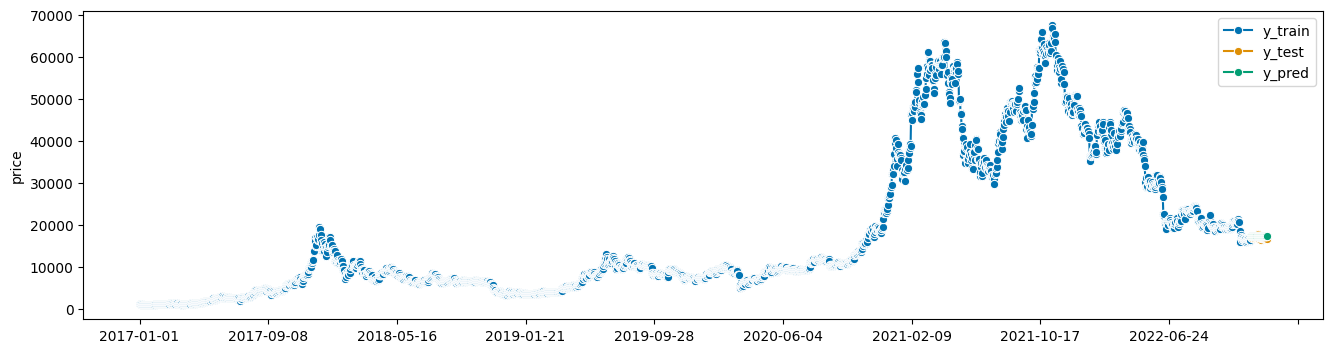

In [ ]:
# y_train と y_test, y_pred で散布図を描く
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='price'>)

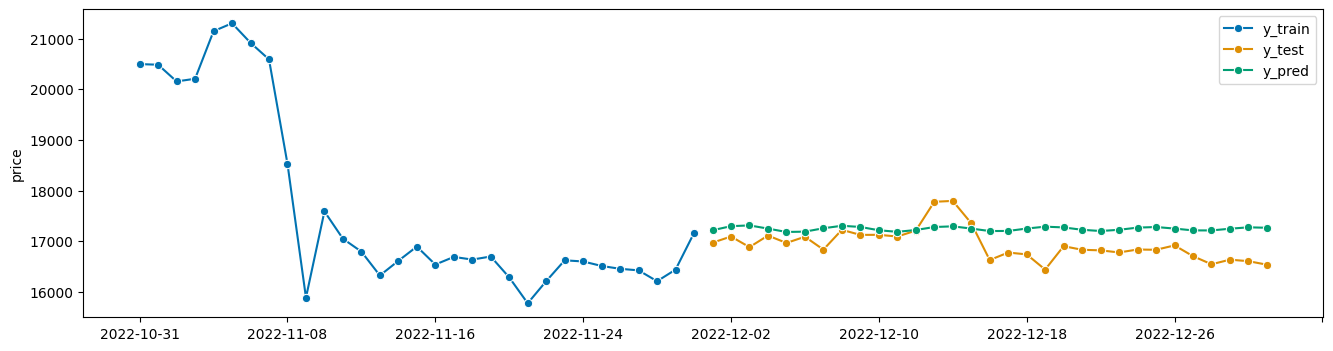

In [ ]:
# 2021年12月から2022年1月末までに絞って散布図を描く
plot_series(y_train.tail(31), y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [ ]:
# y_predの値を表示する
y_pred

,price
2022-12-01,17217.248156
2022-12-02,17297.723133
2022-12-03,17312.974721
2022-12-04,17249.552276
2022-12-05,17183.536155
2022-12-06,17189.552133
2022-12-07,17256.665698
2022-12-08,17305.644375
2022-12-09,17282.276807
2022-12-10,17217.090881


In [ ]:
# MAPEでモデルを評価する
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, y_pred)

0.022294568380431052